In [202]:
import tensorflow
import mp1 as mp1
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
%matplotlib inline

from keras.layers import Input, Dense, Activation
from keras.models import Model, load_model
from keras import optimizers
from keras.utils import to_categorical, normalize
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU, concatenate, UpSampling2D, ReLU
from keras.callbacks import EarlyStopping

# 1 Simple Classification

In [ ]:
[X_train, Y_train] = mp1.generate_dataset_classification(300, 20)

### Look at the train data

In [ ]:
batch_size = 5
fig, ax = plt.subplots(1, batch_size, figsize=(15, 10))

random_batch = random.choices(X_train, k=batch_size)
for i, item in enumerate(random_batch):
    ax[i].imshow(item.reshape(mp1.IMAGE_SIZE, -1), cmap='gray')

In [ ]:
input_shape = X_train[0].shape
nb_neurons = 3
y_train = to_categorical(Y_train)

### SGD optimizer

We use a single layer Network as the task is fairly easy.

In [ ]:
model_sgd = Sequential()
model_sgd.add(Dense(nb_neurons, input_shape=input_shape))
model_sgd.add(Activation('softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001,decay=1e-5, momentum=0.6,nesterov=True)

For a classification problem, mean squared is not appropriate. Rather we use cross-entropy

In [ ]:
model_sgd.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [ ]:
model_sgd.summary()

In [ ]:
loss_sgd = model_sgd.fit(X_train, y_train,batch_size = 32,epochs = 12,validation_split=0.2)

In [ ]:
mp1.plotLossHistory(loss_sgd, metric='acc')
plt.show()

### Adam Optimizer

In [ ]:
model_adam = Sequential()
model_adam.add(Dense(nb_neurons, input_shape=input_shape))
model_adam.add(Activation('softmax'))

In [ ]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.95, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model_adam.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [ ]:
loss_adam = model_adam.fit(X_train, y_train,batch_size = 32,epochs = 12,validation_split=0.2)

In [ ]:
mp1.plotLossHistory(loss_adam, metric='acc')
plt.show()

### Test of the solution

In [ ]:
X_test = mp1.generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

In [ ]:
X_r = mp1.generate_a_rectangle()
X_r = X_r.reshape(1, X_r.shape[0])
model_adam.predict(X_r)

In [ ]:
X_triangle = mp1.generate_a_triangle()[0]
X_triangle = X_triangle.reshape(1, X_triangle.shape[0])
model_adam.predict(X_triangle)

### Visualization of the solution

In [ ]:
weights_sgd = model_sgd.get_weights()[0]
weights_adam = model_adam.get_weights()[0]

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

w0 = weights_sgd[:,0].reshape(mp1.IMAGE_SIZE, -1)
ax[0, 0].imshow(w0, cmap='gray')
ax[0, 0].set_title("Rectangle SGD")

w1 = weights_sgd[:,1].reshape(mp1.IMAGE_SIZE, -1)
ax[0, 1].imshow(w1, cmap='gray')
ax[0, 1].set_title("Circle SGD")

w2 = weights_sgd[:,2].reshape(mp1.IMAGE_SIZE, -1)
ax[0, 2].imshow(w2, cmap='gray')
ax[0, 2].set_title("Triangle SGD")



wa0 = weights_adam[:,0].reshape(mp1.IMAGE_SIZE, -1)
ax[1, 0].imshow(wa0, cmap='gray')
ax[1, 0].set_title("Rectangle Adam")

wa1 = weights_adam[:,1].reshape(mp1.IMAGE_SIZE, -1)
ax[1, 1].imshow(wa1, cmap='gray')
ax[1, 1].set_title("Circle Adam")

wa2 = weights_adam[:,2].reshape(mp1.IMAGE_SIZE, -1)
ax[1, 2].imshow(wa2, cmap='gray')
ax[1, 2].set_title("Triangle Adam")

We notice the activation features better with the Adam optimizer than with SGD. This is consistent with the loss performances we have observed and with the theory.

Moreover depending on the shape to classify, we notice that the activation doesn't focus on the same fatures.

# 2 A more difficult classification task

In [2]:
nb_samples = 300
[X_train, Y_train] = mp1.generate_dataset_classification(nb_samples, 20, True)

  1%|          | 2/300 [00:00<00:18, 16.36it/s]

Creating data:


100%|██████████| 300/300 [00:14<00:00, 20.04it/s]


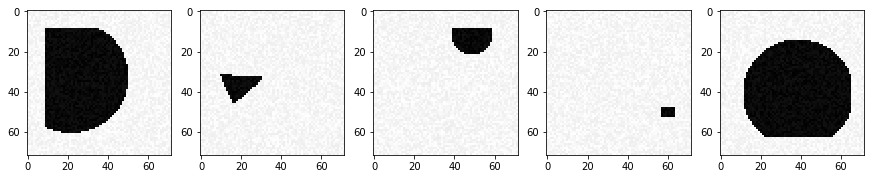

In [3]:
batch_size = 5
fig, ax = plt.subplots(1, batch_size, figsize=(15, 10))

random_batch = random.choices(X_train, k=batch_size)
for i, item in enumerate(random_batch):
    ax[i].imshow(item.reshape(mp1.IMAGE_SIZE, -1), cmap='gray')

### First classification with the same structure as before, with Adam optimizer

In [ ]:
input_shape = X_train[0].shape
nb_neurons = 3
y_train = to_categorical(Y_train)

In [ ]:
model_adam_noise = Sequential()
model_adam_noise.add(Dense(nb_neurons, input_shape=input_shape))
model_adam_noise.add(Activation('softmax'))

In [ ]:
adam_noise = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.95, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model_adam_noise.compile(loss='categorical_crossentropy',optimizer=adam_noise,metrics=['accuracy'])

In [ ]:
loss_adam_noise = model_adam_noise.fit(X_train, y_train,batch_size = 32,epochs = 12,validation_split=0.2)

In [ ]:
mp1.plotLossHistory(loss_adam_noise, metric='acc')
plt.show()

In [ ]:
[X_test, Y_test] = mp1.generate_test_set_classification()

In [ ]:
model_adam_noise.evaluate(X_test, Y_test)

We notice that the classification error is just above 0.5, which shows the bad performance of this classifier. The loss is also twice the value we had on the previous dataset, with the same number of training points.

### Convolutional deep network

In [4]:
from keras.layers import ReLU

In [5]:
input_shape = X_train[0].shape
nb_neurons = 3
y_train = to_categorical(Y_train)

In [6]:
# Input layer
x_in = Input(shape=(mp1.IMAGE_SIZE, mp1.IMAGE_SIZE, 1))

# Convolutional layer
x = Conv2D(16, kernel_size=5)(x_in)
#x = ReLU()(x)
x = LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Fully connected
x = Dense(units=nb_neurons, activation='softmax')(x)

conv_model = Model(inputs=[x_in], outputs=[x])

In [7]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 68, 68, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1183808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [8]:
adam_noise2 = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.95, epsilon=None, decay=0.0, amsgrad=False)

In [9]:
conv_model.compile(loss='categorical_crossentropy', metrics = ['accuracy'],optimizer=adam_noise2)

loss_conv = conv_model.fit(X_train.reshape(nb_samples, 72, 72, 1), 
                      y_train,
                      batch_size = 100,
                      epochs = 40,
                      validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/40
240/240 [==============================] - 1s 6ms/step - loss: 2.1160 - acc: 0.3417 - val_loss: 1.9284 - val_acc: 0.3500
Epoch 2/40
240/240 [==============================] - 1s 3ms/step - loss: 1.8989 - acc: 0.3333 - val_loss: 1.2517 - val_acc: 0.3667
Epoch 3/40
240/240 [==============================] - 1s 4ms/step - loss: 1.4362 - acc: 0.3208 - val_loss: 1.0674 - val_acc: 0.3667
Epoch 4/40
240/240 [==============================] - 1s 3ms/step - loss: 1.0944 - acc: 0.3708 - val_loss: 1.0949 - val_acc: 0.2833
Epoch 5/40
240/240 [==============================] - 1s 3ms/step - loss: 1.0775 - acc: 0.4375 - val_loss: 1.0726 - val_acc: 0.6000
Epoch 6/40
240/240 [==============================] - 1s 3ms/step - loss: 1.0892 - acc: 0.4250 - val_loss: 1.0492 - val_acc: 0.4333
Epoch 7/40
240/240 [==============================] - 1s 3ms/step - loss: 1.0306 - acc: 0.4375 - val_loss: 1.0220 - val_acc: 0.5667
Epoch 8/40
240/240 [===========

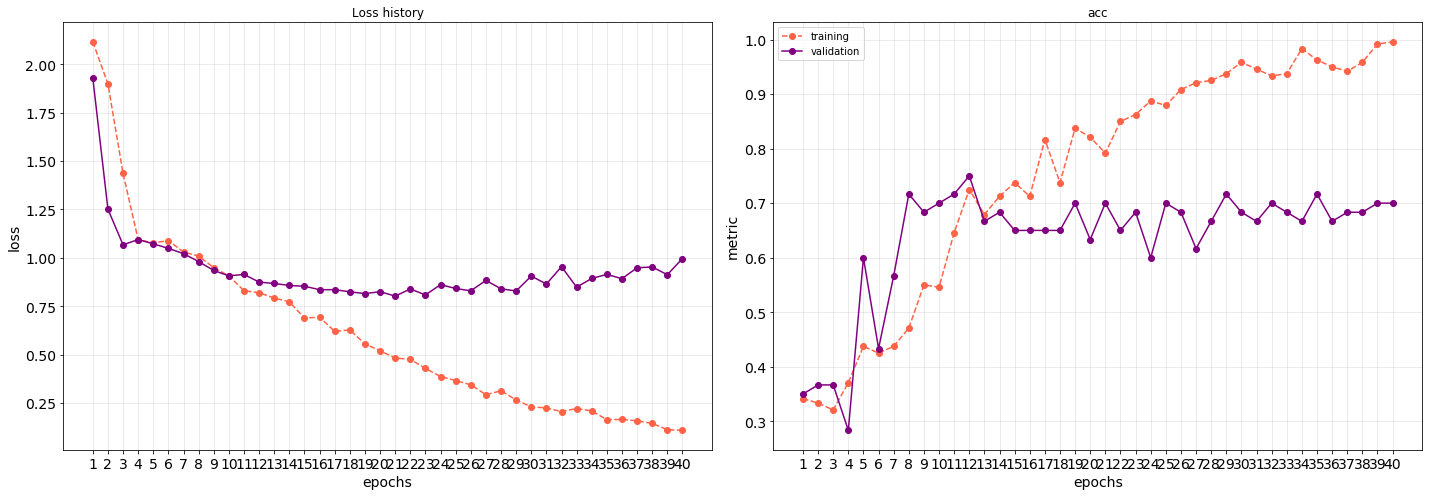

In [10]:
mp1.plotLossHistory(loss_conv, metric='acc')
plt.show()

In [11]:
[X_test, Y_test] = mp1.generate_test_set_classification()

  1%|          | 2/300 [00:00<00:18, 16.38it/s]

Creating data:


100%|██████████| 300/300 [00:15<00:00, 19.53it/s]


In [15]:
conv_model.evaluate(X_test.reshape(X_test.shape[0], 72, 72, 1), Y_test)

300/300 [==============================] - 0s 2ms/step


[0.8119261384010314, 0.7166666666666667]

Performances with the CNN are way better than with the previous network, but could still be better. Adding more layers, or increasing the number of samples (which is quite low) would be ways to improve the performances.

# 3 A regression Problem

In [144]:
[X_train, Y_train] = mp1.generate_dataset_regression(10000, 20)
[X_test, Y_test] = mp1.generate_test_set_regression()

  0%|          | 2/10000 [00:00<08:43, 19.11it/s]

Creating data:


  1%|          | 2/300 [00:00<00:16, 18.16it/s]

Creating data:


100%|██████████| 300/300 [00:15<00:00, 19.66it/s]


In [145]:
n_sample = len(X_train)
input_shape = (mp1.IMAGE_SIZE, mp1.IMAGE_SIZE, 1)

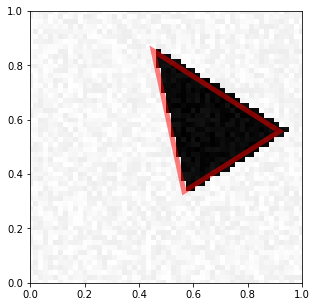

In [108]:
mp1.visualize_prediction(X_train[0], Y_train[0])

I can't explain it but it appears after testing it that the network works better on normalized points.

In [146]:
def normalize_dataset(X, Y):
    max_val = np.max(X)
    min_val = np.min(X)
    X = (X - min_val) / (max_val - min_val) - 0.5
    Y = (Y - min_val) / (max_val - min_val) - 0.5
    return [X, Y]

We sort the vertices according to the x axis (could have been according to y as well). Otherwise, the same set of vertices (hence the same triangle) could be represented by two different arrays, which could deteriorate the performances of the algorithm.

In [147]:
def sort_vert(vertices_arr):
    vertices = list(vertices_arr.reshape(3, 2))
    vertices.sort(key=lambda x: x[0])
    return np.ravel(vertices)

In [148]:
y_train = np.array([sort_vert(i) for i in Y_train])
y_test = np.array([sort_vert(i) for i in Y_test])

[X_train, y_train] = normalize_dataset(X_train, y_train)
[X_test, y_test] = normalize_dataset(X_test, y_test)

The model we chose for this task is first constituted by a "normal" convolutional block (with the same tunning parameters and choices as for the classification task: leakyrelu, dropout, etc). 
On top of this, we add 3 separate dense branches, whose respective goal is to detect a given edge (following the x-axis).

In [160]:
x_in = Input(shape=input_shape)

# Convolutional blocks
x = Conv2D(16, kernel_size=5)(x_in)
x = LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, kernel_size=3)(x)
x = LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=3)(x)
x = LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)


# First branch
x1 = Dense(36, activation="relu")(x)
x1 = Dropout(0.5)(x1)
x1 = Dense(units=2)(x1)

# Second branch
x2 = Dense(36, activation="relu")(x)
x2 = Dropout(0.5)(x2)
x2 = Dense(units=2)(x2)

# Third branch
x3 = Dense(36, activation="relu")(x)
x3 = Dropout(0.5)(x3)
x3 = Dense(units=2)(x3)


# Output layer
x_out = concatenate([x1, x2, x3])

regression_model = Model(inputs=[x_in], outputs=[x_out])

In [161]:
regression_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 68, 68, 16)   416         input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_20 (LeakyReLU)      (None, 68, 68, 16)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 34, 34, 16)   0           leaky_re_lu_20[0][0]             
__________________________________________________________________________________________________
conv2d_21 

In [174]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.995, epsilon=None, decay=0.01, amsgrad=False) 
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2)

In [175]:
regression_model.compile(loss='mean_squared_error', 
                   optimizer=adam,metrics=['accuracy'])

In [176]:
regression_loss = regression_model.fit(X_train.reshape((n_sample,) + input_shape), 
                      y_train,
                      batch_size = 256,
                      epochs = 20,
                      validation_split=0.2)        

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 55s 7ms/step - loss: 15.8409 - acc: 0.2841 - val_loss: 0.0387 - val_acc: 0.5845
Epoch 2/20
8000/8000 [==============================] - 44s 6ms/step - loss: 0.0424 - acc: 0.5799 - val_loss: 0.0245 - val_acc: 0.6815
Epoch 3/20
8000/8000 [==============================] - 44s 6ms/step - loss: 0.0327 - acc: 0.6257 - val_loss: 0.0211 - val_acc: 0.7185
Epoch 4/20
8000/8000 [==============================] - 48s 6ms/step - loss: 0.0298 - acc: 0.6502 - val_loss: 0.0194 - val_acc: 0.7320
Epoch 5/20
8000/8000 [==============================] - 51s 6ms/step - loss: 0.0283 - acc: 0.6620 - val_loss: 0.0184 - val_acc: 0.7430
Epoch 6/20
8000/8000 [==============================] - 45s 6ms/step - loss: 0.0272 - acc: 0.6613 - val_loss: 0.0173 - val_acc: 0.7530
Epoch 7/20
8000/8000 [==============================] - 48s 6ms/step - loss: 0.0265 - acc: 0.6689 - val_loss: 0.0166 - val_acc: 0.7620
Epoch 

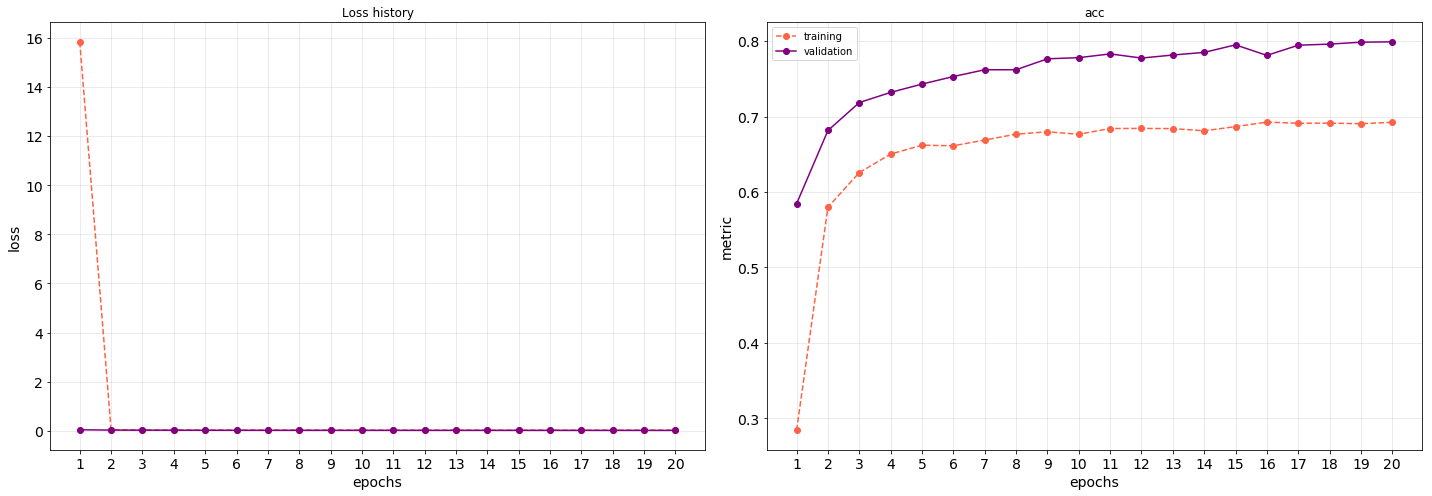

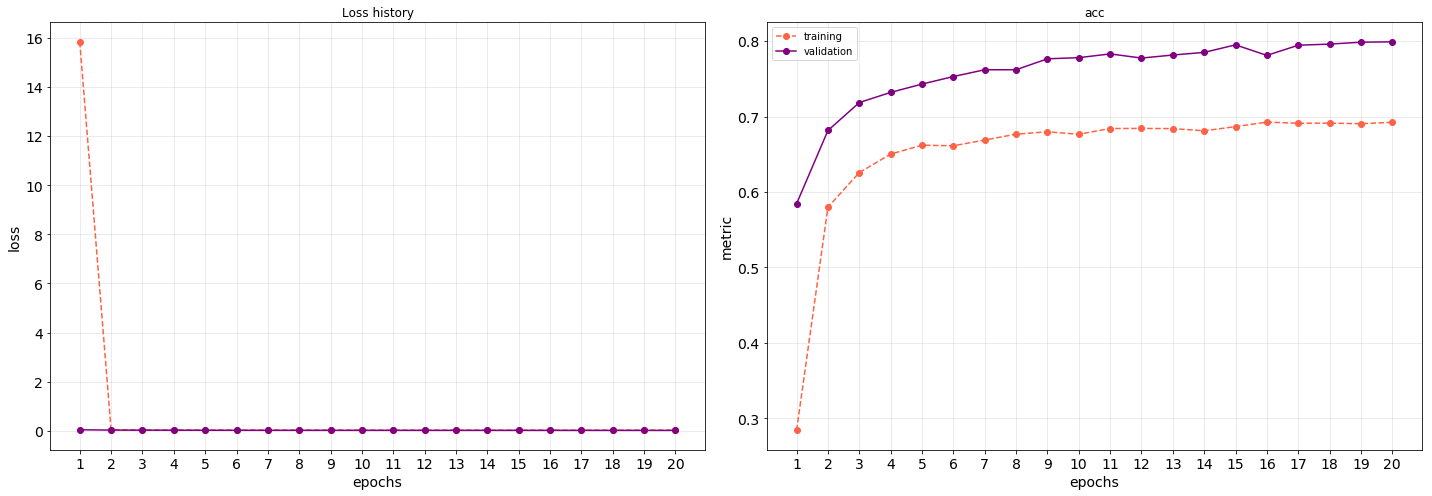

In [177]:
mp1.plotLossHistory(regression_loss,metric='acc')

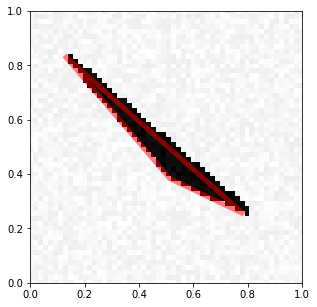

In [156]:
mp1.visualize_prediction(X_train[18], Y_train[18])

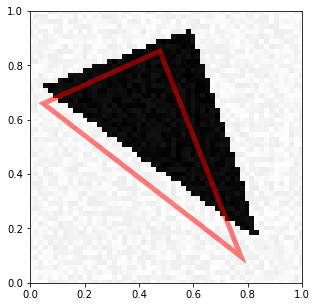

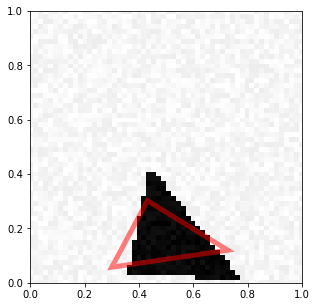

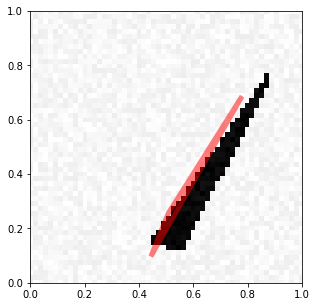

In [185]:
fig_sample = 3
test_samples = random.choices(X_test, k=fig_sample)
for sample in test_samples:
    pred = regression_model.predict(sample.reshape((1,) + input_shape)) + 0.5 # to recenter the dataset between 0 and 1
    mp1.visualize_prediction(sample, pred)

#### Comments
In comparison with the previous experiments, the task of regression is much harder. Hence we need more sample in order to obtain a quite satisfactory result. As before, incresaing the number of epochs also improves the performance but not as much as increasing the number of samples.

Although the model is quite naive, the results are not too bad. More complicated (and deep) networks could help improving the performance: popular networks used for object segmentation includ U-net or SegNet.

# 4 Image denoising

In [186]:
from tqdm import tqdm

In [191]:
def generate_noise_dataset(nb_samples, max_noise=50, min_noise=20, free_location=True):
    # Getting im size
    im_size = mp1.generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in tqdm(range(nb_samples)):
        category = np.random.randint(3)
        noise = min_noise + (max_noise - min_noise) * np.random.rand() # to have different noise amplitude
        seed = np.random.randint(10 * nb_samples) # set the seed at a certain number to get saem figures for X and Y
        np.random.seed(seed)
        if category == 0:
            X[i] = mp1.generate_a_rectangle(noise=noise, free_location=free_location)
            np.random.seed(seed)
            Y[i] = mp1.generate_a_rectangle(free_location=free_location)
        elif category == 1:
            X[i] = mp1.generate_a_disk(noise=noise, free_location=free_location)
            np.random.seed(seed)
            Y[i] = mp1.generate_a_disk(free_location=free_location)
        else:
            [X[i], _] = mp1.generate_a_triangle(noise=noise, free_location=free_location)
            np.random.seed(seed)
            [Y[i], _] = mp1.generate_a_triangle(free_location=free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255.
    return [X, Y]

In [193]:
[X_train, Y_train] = generate_noise_dataset(300)
[X_test, Y_test] = generate_noise_dataset(30)

  0%|          | 1/300 [00:00<00:33,  8.97it/s]

Creating data:


  3%|▎         | 1/30 [00:00<00:03,  9.52it/s]

Creating data:


100%|██████████| 30/30 [00:03<00:00,  9.57it/s]


In [194]:
n_sample = len(X_train)
input_shape = (mp1.IMAGE_SIZE, mp1.IMAGE_SIZE, 1)

As seen during the course, we choose a U-Net architecture to operate denoising. In comparison with more classical autoencoders, it helps lowering the blurring effect on the data.

We also used U-Net because it was easy to self implement i, in comparison with more complex networks as SegNet or RedNet that are supposed to yield better performances.  

In [200]:
# Input layer
x_in = Input(shape=input_shape)

# Down path
x_enc1 = Conv2D(16, kernel_size=5, padding='same')(x_in)
x_enc1 = ReLU()(x_enc1)
x_enc1 = MaxPooling2D(pool_size=(2,2))(x_enc1)

x_enc2 = Conv2D(32, kernel_size=3, padding='same')(x_enc1)
x_enc2 = ReLU()(x_enc2)
x_enc2 = MaxPooling2D(pool_size=(2,2))(x_enc2)

# Up path
x_dec = Conv2D(16, kernel_size=3, padding='same')(x_enc2)
x_dec = ReLU()(x_dec)
x_dec = UpSampling2D()(x_dec)
x_dec = concatenate([x_dec, x_enc1])

x_dec = Conv2D(16, kernel_size=3, padding='same')(x_dec)
x_dec = ReLU()(x_dec)
x_dec = UpSampling2D()(x_dec)
x_dec = concatenate([x_dec, x_in])

x_dec = Conv2D(1, kernel_size=3, padding='same', activation="sigmoid")(x_dec)

unet_model = Model(inputs=[x_in], outputs=[x_dec])

In [201]:
unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 72, 72, 16)   416         input_13[0][0]                   
__________________________________________________________________________________________________
re_lu_16 (ReLU)                 (None, 72, 72, 16)   0           conv2d_41[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 36, 36, 16)   0           re_lu_16[0][0]                   
__________________________________________________________________________________________________
conv2d_42 

In [203]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0001, amsgrad=False) 
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=1e-3,
                               patience=5)

In [206]:
unet_model.compile(loss='mean_squared_error', 
                   optimizer=adam,metrics=['accuracy'])

In [207]:
unet_loss = unet_model.fit(X_train.reshape((n_sample,) + input_shape), 
                           Y_train.reshape((n_sample,) + input_shape),
                           batch_size = 128,
                           epochs = 10,
                           validation_split=0.2,
                           callbacks=[early_stopping])

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 5s 20ms/step - loss: 0.0513 - acc: 0.9126 - val_loss: 0.0502 - val_acc: 0.9263
Epoch 2/10
240/240 [==============================] - 3s 14ms/step - loss: 0.0465 - acc: 0.9323 - val_loss: 0.0430 - val_acc: 0.9301
Epoch 3/10
240/240 [==============================] - 3s 13ms/step - loss: 0.0393 - acc: 0.9378 - val_loss: 0.0347 - val_acc: 0.9566
Epoch 4/10
240/240 [==============================] - 3s 12ms/step - loss: 0.0316 - acc: 0.9659 - val_loss: 0.0259 - val_acc: 0.9729
Epoch 5/10
240/240 [==============================] - 3s 13ms/step - loss: 0.0233 - acc: 0.9764 - val_loss: 0.0190 - val_acc: 0.9866
Epoch 6/10
240/240 [==============================] - 3s 13ms/step - loss: 0.0172 - acc: 0.9887 - val_loss: 0.0141 - val_acc: 0.9879
Epoch 7/10
240/240 [==============================] - 3s 13ms/step - loss: 0.0126 - acc: 0.9889 - val_loss: 0.0106 - val_acc: 0.9935
Epoch 8/10
240/240 [====

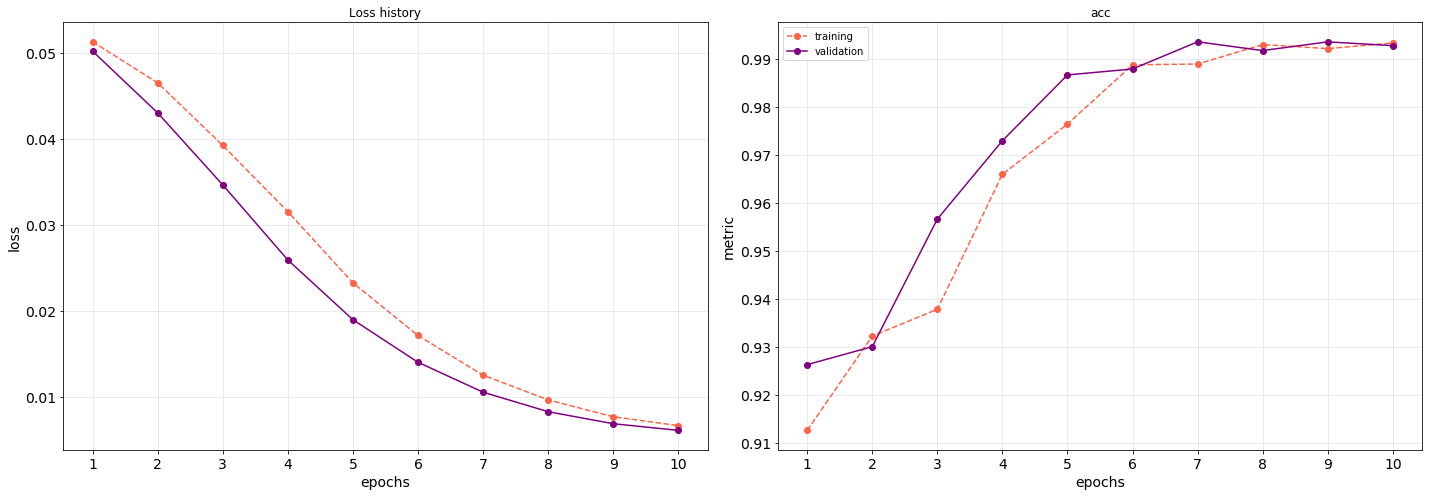

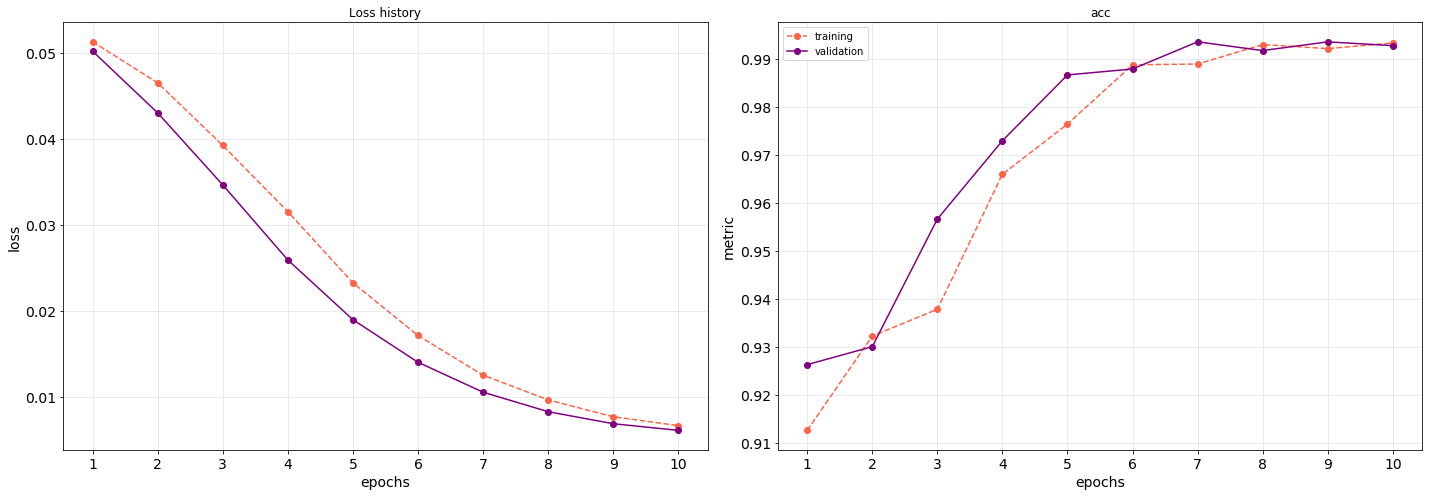

In [208]:
mp1.plotLossHistory(unet_loss,metric='acc')

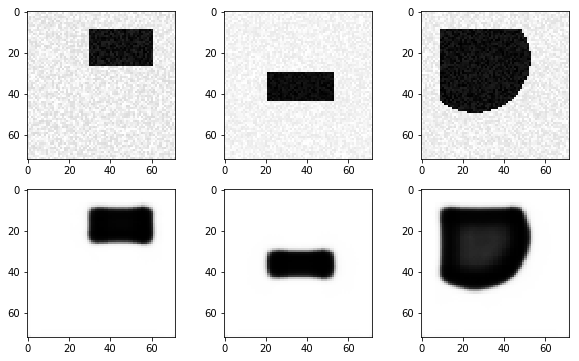

In [217]:
n = 3
test_samples = random.choices(X_test, k=n)

fig, ax = plt.subplots(2, n, figsize=(10, 2*n))
for i, sample in enumerate(test_samples):
    noisy_img = sample.reshape(mp1.IMAGE_SIZE, -1)
    ax[0][i].imshow(noisy_img, cmap='gray')
    denoised_img = unet_model.predict(noisy_img[np.newaxis, :, :, np.newaxis])
    ax[1][i].imshow(denoised_img.reshape(mp1.IMAGE_SIZE, -1), cmap='gray')